#### This notebook covers below 
    - FNN without data augmentation
    - FNN with data augmentation
    - CNN with data augmentation 
    
    

**Note** : Hyperparameters are not tuned. 

In [1]:
import os
import h5py
import pandas as pd
import numpy as np
import livelossplot


import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, TensorDataset, DataLoader
import matplotlib.pyplot as plt

from torchvision import transforms
from PIL import Image

import warnings

In [2]:
## set random seeds
warnings.filterwarnings('ignore')

seed = 121
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

In [3]:
## CONFIG
TRAIN_FILE_PATH = './datasets/train_signs.h5'
TEST_FILE_PATH = './datasets/test_signs.h5'

In [4]:
def load_dataset(train_file_path, test_file_path):
    
    train = h5py.File(train_file_path)
    test = h5py.File(test_file_path)
    
    X_train = train['train_set_x'].value
    y_train = train['train_set_y'].value
    
    X_test = test['test_set_x'].value
    y_test = test['test_set_y'].value
    
    labels = train['list_classes'].value
    
    print("Train data shape :", X_train.shape, y_train.shape)
    print("Test data shape :", X_test.shape, y_test.shape)
    print("Labels :", labels)

    return X_train,y_train,X_test,y_test,labels

In [5]:
## Pytorch Model
class FNN(nn.Module):
    
    def __init__(self, in_features, hidden_features, out_features):
        super(FNN,self).__init__()
        
        self.layer1 = nn.Linear(in_features=in_features,out_features=hidden_features) ## output : batch_size * hidden_features
        self.layer2 = nn.Linear(in_features=hidden_features, out_features=out_features) ## output: batch_size * out_features
         
    def forward(self, inputs):
        
        x = F.relu(self.layer1(inputs))
        x = self.layer2(x)
        return x

In [6]:
def save_model(model_path, model_name, model, optimizer, logs, epoch):
    model_dict = {
        "model": model.state_dict(),
        "optimizer":optimizer.state_dict(),
        "logs":logs,
        "epoch":epoch
    }
    
    os.makedirs(model_path, exist_ok=True)
    model_file_path = os.path.join(model_path,model_name)
    torch.save(model_dict,model_file_path)

In [7]:
def evaluate(model, inputs):
    
    model.eval()
    outputs = model(inputs.float())
    
    preds = F.softmax(outputs)
    preds = torch.argmax(preds, axis=1)
    return preds

def accuracy(preds, labels):
    acc = (torch.sum(preds==labels).item()/len(labels))*100
    return np.round(acc,3)

In [8]:
def train(model, dataloaders, loss_fn, optimizer, num_epochs):
    
    lossplot = livelossplot.PlotLosses()
    min_loss = 9999999
    
    for epoch in range(num_epochs):
        logs = {}
        for phase in ["train","validation"]:
            
            running_loss = 0.0
            running_accuracy = 0
            
            if phase == "train":
                model.train()
            else:
                model.eval()
                
            for inputs, labels in dataloaders[phase]:
                outputs = model(inputs.float())
                loss = loss_fn(outputs, labels)
                
                running_loss += loss.item()
                
                preds = torch.argmax(outputs,axis=1)
                running_accuracy += torch.sum(preds==labels)
                
                
                if phase=="train":
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()
                
            prefix = ''
            if phase=="validation":
                prefix ="val_"
            
            epoch_loss = running_loss/len(dataloaders[phase])
            epoch_acc = running_accuracy.item()/len(dataloaders[phase].dataset)
                
            logs[prefix+'loss'] = np.round(epoch_loss,3)
            logs[prefix+'accuracy'] = np.round(epoch_acc,3)
            
            if phase == "validation":
                if epoch_loss<min_loss:
                    min_loss = epoch_loss
                    save_model('./model','fnn_model.pth',model, optimizer,logs, epoch)
        
        lossplot.update(logs)
        lossplot.send()

## FNN without data augmentation

In [19]:
## Load Data
X_train,y_train,X_test,y_test,labels = load_dataset(TRAIN_FILE_PATH, TEST_FILE_PATH)

Train data shape : (1080, 64, 64, 3) (1080,)
Test data shape : (120, 64, 64, 3) (120,)
Labels : [0 1 2 3 4 5]


## FNN with data augmentation

In [20]:
transformation = transforms.Compose([
    transforms.RandomRotation(20),
    transforms.RandomAffine(10),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter()
])


### Create augmentated data
X_new = []
y_new = []

for img, label in zip(X_train,y_train):
    pil_img = Image.fromarray(img, mode = 'RGB')
    new_img = np.asarray(transformation(pil_img))
    X_new.append(new_img)
    y_new.append(label)
    
    
X_new = np.asarray(X_new)
y_new = np.asarray(y_new)
X_train = np.concatenate([X_train,X_new])
y_train = np.concatenate([y_train,y_new])

## Model Traning

In [21]:
## Normalize input 
X_train = X_train/255.0
X_test = X_test/255.0
    
### Convert data to pytorch tensor
X_train = torch.from_numpy(X_train)
y_train = torch.from_numpy(y_train)
X_test = torch.from_numpy(X_test)
y_test = torch.from_numpy(y_test)

## Copy data for cnn model
X_train_cnn, y_train_cnn, X_test_cnn, y_test_cnn = X_train, y_train,X_test,y_test

### Convert data to pytorch FNN input
X_train = X_train.view(X_train.shape[0],-1)
X_test = X_test.view(X_test.shape[0],-1)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

(torch.Size([2160, 12288]),
 torch.Size([2160]),
 torch.Size([120, 12288]),
 torch.Size([120]))

In [12]:
## Model config
batch_size = 64
epochs = 50
learning_rate = 0.0005

in_features = X_train.shape[1]
hidden_features = 100
out_features = len(labels)

device = "cuda" if torch.cuda.is_available() else "cpu"

In [13]:
## Create dataset and dataloader
## you can also create the custom class for dataset
train_ds = TensorDataset(X_train,y_train)
test_ds = TensorDataset(X_test, y_test)

train_dl = DataLoader(train_ds, batch_size = batch_size, shuffle= True)
test_dl = DataLoader(test_ds, batch_size = batch_size, shuffle = False)

dataloaders = {
    "train": train_dl,
    "validation" : test_dl
}

model = FNN(in_features,hidden_features,out_features)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = learning_rate)

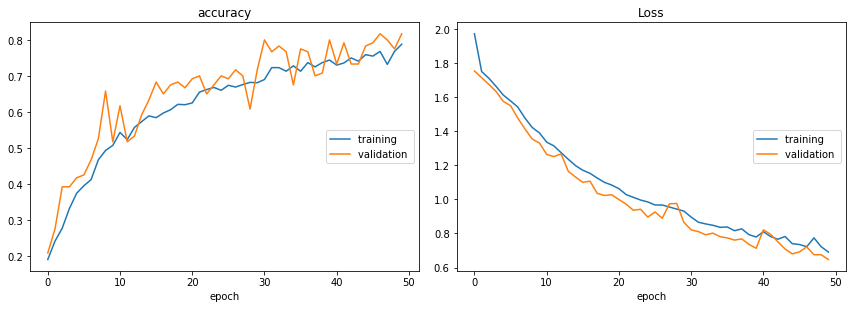

accuracy
	training         	 (min:    0.190, max:    0.788, cur:    0.788)
	validation       	 (min:    0.208, max:    0.817, cur:    0.817)
Loss
	training         	 (min:    0.691, max:    1.972, cur:    0.691)
	validation       	 (min:    0.647, max:    1.754, cur:    0.647)


In [14]:
train(model , dataloaders, loss_fn, optimizer, epochs)

In [15]:
## Load model
model_file_path = './model/fnn_model.pth'
model_dict = torch.load(model_file_path)

model = FNN(in_features,hidden_features,out_features)
model.load_state_dict(model_dict['model'])

preds = evaluate(model, X_test)
print("Test Accuracy :", accuracy(preds,y_test))

Test Accuracy : 81.667


## CNN

In [ ]:
X_train_cnn.shape, y_train_cnn.shape, X_test_cnn.shape, y_test_cnn.shape

In [ ]:
X_train_cnn = X_train_cnn.permute(0,3,1,2)
X_test_cnn = X_test_cnn.permute(0,3,1,2)
X_train_cnn.shape, X_test_cnn.shape

In [84]:
class CNN(nn.Module):
    
    def __init__(self, in_channels, out_labels):
        super(CNN, self).__init__()
        
        self.cnn_layer = nn.Sequential(
            
            # layer 1
            nn.Conv2d(in_channels = in_channels, out_channels = 16, kernel_size=3,stride=1,padding=0),
            nn.ReLU(inplace = True),
            nn.MaxPool2d(kernel_size=2,stride=1,padding=0),
            
            # layer 2
            nn.Conv2d(in_channels = 16, out_channels = 32, kernel_size=5,stride=1,padding=1),
            nn.ReLU(inplace = True),
            nn.MaxPool2d(kernel_size=2,stride=1,padding=0),
            
            # layer 3
            nn.Conv2d(in_channels = 32, out_channels = 32, kernel_size=5,stride=1,padding=1),
            nn.ReLU(inplace = True),
            nn.MaxPool2d(kernel_size=3,stride=1,padding=1)
        )
        self.linear_layer = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features = 32 * 56 * 56,out_features = 512),
            nn.ReLU(inplace = True),
            nn.Dropout(p=0.15),
            nn.Linear(512, out_labels)
            
        )
    
    def forward(self, inputs):
        x = self.cnn_layer(inputs)
#         print(x.shape)
        x = self.linear_layer(x)
        return x

In [85]:
## Model config
batch_size = 64
epochs = 10
learning_rate = 0.0005

in_features = X_train_cnn.shape[1]

In [86]:
## Create dataset and dataloader
## you can also create the custom class for dataset
train_ds = TensorDataset(X_train_cnn,y_train)
test_ds = TensorDataset(X_test_cnn, y_test)

train_dl = DataLoader(train_ds, batch_size = batch_size, shuffle= True)
test_dl = DataLoader(test_ds, batch_size = batch_size, shuffle = False)

dataloaders = {
    "train": train_dl,
    "validation" : test_dl
}

model = CNN(in_channels = in_features,out_labels=len(labels))
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = learning_rate)

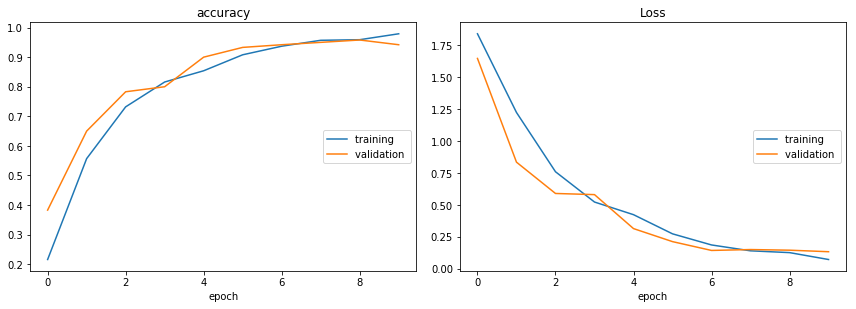

accuracy
	training         	 (min:    0.216, max:    0.979, cur:    0.979)
	validation       	 (min:    0.383, max:    0.958, cur:    0.942)
Loss
	training         	 (min:    0.072, max:    1.839, cur:    0.072)
	validation       	 (min:    0.133, max:    1.646, cur:    0.133)


In [87]:
train(model , dataloaders, loss_fn, optimizer, epochs)

In [88]:
## Load model
model_file_path = './model/fnn_model.pth'
model_dict = torch.load(model_file_path)

model = CNN(in_channels = in_features,out_labels=len(labels))
model.load_state_dict(model_dict['model'])

preds = evaluate(model, X_test_cnn)
print("Test Accuracy :", accuracy(preds,y_test))

Test Accuracy : 94.167


#### Results

    - FNN without data augmentation accuracy : 77.5 %
    - FNN with data augmentation accuracy : 83.33% 
    - CNN with data augmentation accuracy : 94.16%